# Human presence sub-model - Notebook 3

* **Products used:** 
[cgls_landcover](https://explorer.digitalearth.africa/products/cgls_landcover), 
[OpenStreetMap](https://www.openstreetmap.org/),
[High Resolution Population Density Maps + Demographic Estimates by CIESIN and Meta](https://registry.opendata.aws/dataforgood-fb-hrsl/)

## Background

This notebook calculates and stores the third sub-model in the elephant Habitat Suitability Model; the human presence sub-model. It has the data layers and weightings listed in the table below. 


Data layer | Layer weighting |
-----------: | -----------: |
Urban development (CGLS 50) | 25% | 
Cropland (CGLS 40) | 25% |
Human population density | 25% |
Roads | 25% |

The workflow comprises the following steps:

   1. Define an area of interest and load packages.
   2. Load landcover CGLS data and select the cropland and urban cover layers.
   3. Within the area of interest, calculate proximity to croplands and urban areas quantified as euclidean distance in metres.
   4. Standardise the euclidean distance measure so it ranges between 0 and 1.
   5. Bring in human population density and roads data from external sources and repeat steaps 3 & 4 on these layers.
   6. Use a weighted linear combination approach to estimate habitat suitability.
   7. Visualise the habitat suitability model.

### Load packages
Import Python packages that are used for the analysis, including those used for calculating euclidean distance and importing population density and roads datasets.

In [1]:
%matplotlib inline

import datacube
import os
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from odc.algo import xr_reproject
from deafrica_tools.plotting import plot_lulc
from deafrica_tools.spatial import xr_vectorize, xr_rasterize

try:
    import osmnx as ox
except:
    import os
    os.system('pip install osmnx')
    import osmnx as ox
    
try:
    import xrspatial
except:
      !pip install xrspatial
    
from xrspatial import proximity

/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/local/lib/python3.8/dist-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pa

### Connect to the datacube

Connect to the datacube so we can access DE Africa data.

In [2]:
dc = datacube.Datacube(app='Elephant-HSM-human')

## Load CGLS landcover

In [3]:
%store -r query

ds_cgls = dc.load(product='cgls_landcover', **query).squeeze()

# Urban development

Urban development refers to cities, towns, and other built-up centres. There are a few dotted throughout the default area of interest as shown in the plot below.

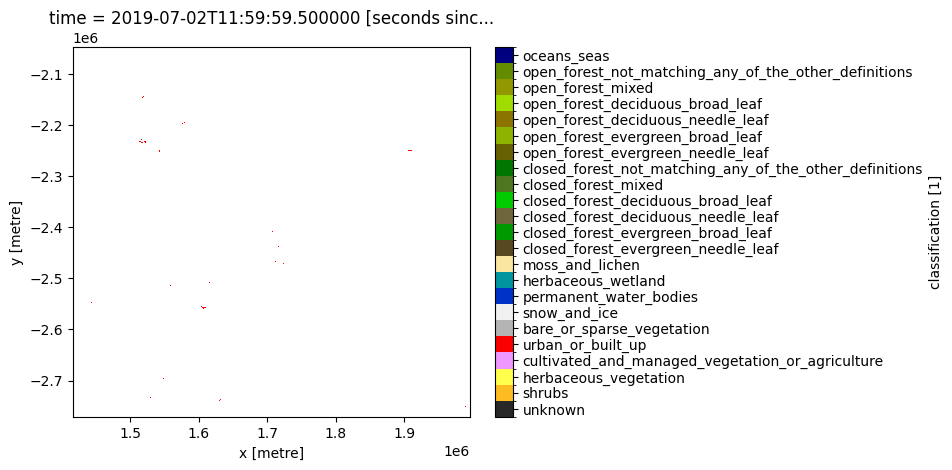

In [4]:
plot_lulc(ds_cgls.where(ds_cgls==50)['classification'], product="CGLS", legend=True)

Note that urban development is considered undesirable elephant habitat, so areas furthest are assigned values around `1`, while areas of urban development are shown as `0` in the plot below.

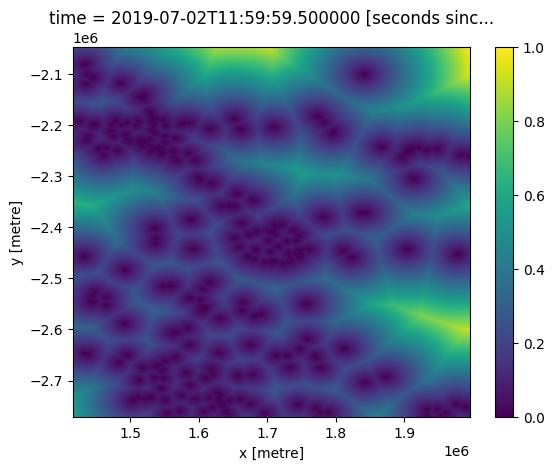

In [5]:
cgls_urban = ds_cgls.where(ds_cgls==50)

urban_proximity = proximity(cgls_urban.classification, distance_metric='EUCLIDEAN')

urban_proximity_std = urban_proximity/np.max(urban_proximity)

urban_proximity_std.plot()

## Croplands

The process is repeated for croplands which are again considered undesirable elephant habitat.

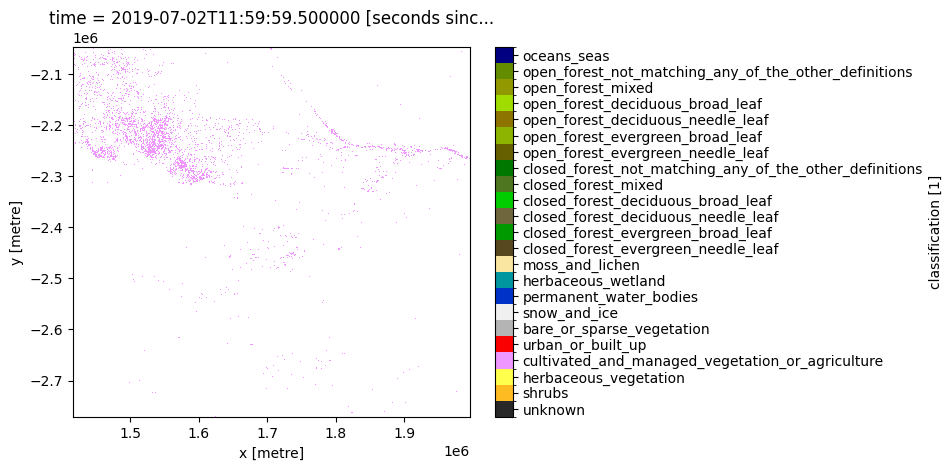

In [6]:
plot_lulc(ds_cgls.where(ds_cgls==40)['classification'], product="CGLS", legend=True)

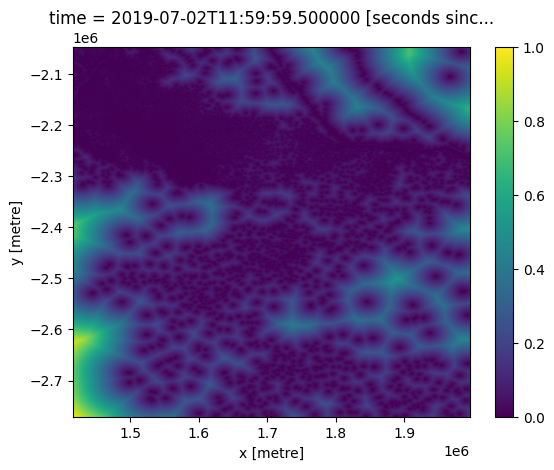

In [7]:
cgls_crops = ds_cgls.where(ds_cgls==40)

proximity_crops = proximity(cgls_crops.classification, distance_metric = 'EUCLIDEAN')

crops_proximity_std = proximity_crops/np.max(proximity_crops)

crops_proximity_std.plot()

# Population density data

Human population density data is not available in CGLS like other layers, so we draw it from an external source ([Data for Good hosted on AWS](https://docs.opendata.aws/dataforgood-fb-data/readme.html)) with the code below.

In [8]:
os.environ['AWS_DEFAULT_REGION']="us-east-1"
os.environ['AWS_S3_ENDPOINT']="s3.us-east-1.amazonaws.com"

ds_general = rxr.open_rasterio('s3://dataforgood-fb-data/hrsl-cogs/hrsl_general/hrsl_general-latest.vrt', chunks ={'x': 1000, 'y': 1000})

We draw upon the stored spatial variables from the initial notebook.

In [9]:
%store -r lons
%store -r lats

xmin = lons[0]
xmax = lons[1]
ymin = lats[0]
ymax = lats[1]

# load the data within area of interest
pop_general = ds_general.isel(band=0).sel(x=slice(
    xmin, xmax), y = slice(ymax, ymin)).coarsen(
    x=6).mean().coarsen(y=6).mean().compute().rio.reproject("EPSG:6933")

/usr/local/lib/python3.8/dist-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


The below cell repeats the euclidean distance and standardisation calculations on the population density layer.

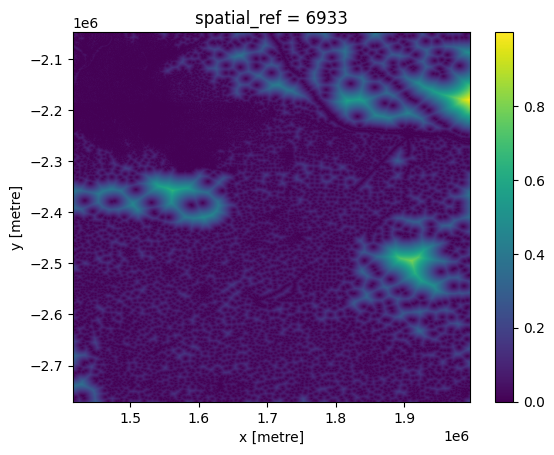

In [10]:
popn_proximity = proximity(pop_general, distance_metric='EUCLIDEAN')

popn_proximity_std = popn_proximity/np.max(popn_proximity)

popn_proximity_std = xr_reproject(src=popn_proximity_std,
                              geobox=ds_cgls.geobox,
                              resampling="average")

popn_proximity_std.plot()

# Roads - Open Street Map

Similar to the human population density data, we must bring in roads data from an external source, in this case Open Street Map. 

In [ ]:
ox.settings.cache_folder='/tmp/cache/'

# selected types of roads
tags = {'highway': ['motorway', 'motorway_link', 'primary', 'primary_link',
                    'secondary', 'secondary_link', 'tertiary', 'tertiary_link', 
                    'residential', 'pedestrian']}

geometries = ox.geometries_from_bbox(ymax, ymin, xmax, xmin, tags)

#visualize the geometries retrieved
geometries.plot(figsize=(8,10), cmap='tab10', column='highway', categorical=True, categories=tags['highway'], legend=True);

We need raster data in `xarray` to calculate euclidean distance, so we rasterize the roads vector data in the cell below.

In [ ]:
xr_roads = xr_rasterize(geometries, da=ds_cgls)

The distance calculation is then repeated on the roads data.

In [ ]:
roads_proximity = proximity(xr_roads, distance_metric='EUCLIDEAN')

roads_proximity_std = roads_proximity/np.max(roads_proximity)
roads_proximity_std.plot()

# Weighted Linear Combination

The table at the beginning of the notebook shows that the four layers are allocated an equal weighting of 25%. We can see that the result depicts higher values in areas where human presence is lowest.

In [ ]:
weight=0.25

hp_model=(roads_proximity_std*weight)+(
    urban_proximity_std*weight)+(
    popn_proximity_std*weight)+(
    crops_proximity_std*weight)

hp_model.plot()

## Save to outputs

In [ ]:
hp_model = hp_model.drop('time', dim=None)
hp_model.to_netcdf('outputs/hp_sm.nc')

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')